# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

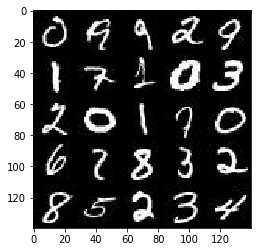

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

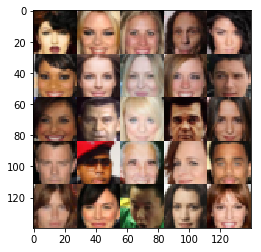

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    inputs_real = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='inputs_real')
    inputs_z = tf.placeholder(tf.float32, [None, z_dim], name='inputs_z')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
import numpy as np
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    #leaky relu hyperparameter
    alpha = 0.2
    #droupout hyperparameter
    drop_rate = 0.4
    
    with tf.variable_scope('discriminator', reuse=reuse):
        #28x28
        conv = tf.layers.conv2d(images, 128, 5, strides=4, padding='same')
        conv = tf.maximum(alpha * conv, conv) #leaky relu allows gradient to flow
        conv = tf.layers.dropout(conv, drop_rate, training=True) #improves generalization and gets generator a chance to learn
        #print(conv.get_shape().as_list())
        
        #7x7x128
        conv = tf.layers.conv2d(conv, 256, 5, strides=2, padding='same')
        conv = tf.layers.batch_normalization(conv, training=True)
        conv = tf.maximum(alpha * conv, conv)
        conv = tf.layers.dropout(conv, drop_rate, training=True) #improves generalization and gets generator a chance to learn
        #print(conv.get_shape().as_list())
        
        #layer removed in order to make the discriminator less expressive (giving advantage to generator)
        #conv = tf.layers.conv2d(conv, 512, 4, strides=2, padding='same')
        #conv = tf.layers.batch_normalization(conv, training=True)
        #conv = tf.maximum(alpha * conv, conv)
        #conv = tf.layers.dropout(conv, drop_rate, training=True)
        #print(conv.get_shape().as_list())
     
        #4x4x256
        flatten_shape = np.prod(conv.get_shape().as_list()[1:])
        flatten = tf.reshape(conv, [-1, flatten_shape])
        #print("Flatten shape: {}".format(flatten_shape))
    
        #classifier
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)
    
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    #leaky relu hyperparameter
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        z = tf.layers.dense(z, 4*4*512, 
                            use_bias=False,
                            activation=None)
        z = tf.reshape(z, [-1, 4, 4, 512])
        z = tf.layers.batch_normalization(z, training=is_train)
        z = tf.maximum(alpha * z, z)
        
        #print(z.get_shape().as_list())
        
        #4x4x512
        conv = tf.layers.conv2d_transpose(z, 256, 4, strides=1, padding='valid',
                                          use_bias=False,
                                          activation=None)
        conv = tf.layers.batch_normalization(conv, training=is_train)
        conv = tf.maximum(alpha * conv, conv)
        #print(conv.get_shape().as_list())

        
        #7x7x256
        conv = tf.layers.conv2d_transpose(conv, 128, 5, strides=2, padding='same',
                                          use_bias=False,
                                          activation=None)
        conv = tf.layers.batch_normalization(conv, training=is_train)
        conv = tf.maximum(alpha * conv, conv)
        #print(conv.get_shape().as_list())
        
        #14x14x128
        conv = tf.layers.conv2d_transpose(conv, out_channel_dim, 5, strides=2, padding='same',
                                          use_bias=False,
                                          activation=None)
        #print(conv.get_shape().as_list())
           
    return tf.nn.tanh(conv)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """

    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)
    
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake))
                           )
    
    #avoiding 1's for real logits, we have to reduce these to allow generator to improve
    label_smoothing = 0.9
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real) * label_smoothing)
                           )
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake))
                           )
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    #retrieving trainable vars
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    #getting update ops for each one
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_update_ops = [op for op in update_ops if op.name.startswith('discriminator')]
    g_update_ops = [op for op in update_ops if op.name.startswith('generator')]
    
    #
    with tf.control_dependencies(d_update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    
    with tf.control_dependencies(g_update_ops):
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import numpy as np
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    #image mode
    out_channel_dim = 3 if data_image_mode == 'RGB' else 1

    #inputs, loss models and optmizers
    input_real, input_z, lr = model_inputs(*(data_shape[1:]), z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, out_channel_dim)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    
    ##
    step = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                step += 1
                
                #generate random sample
                z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                #images are in range [-0.5, 0.5], changing to [-1, 1]
                batch_images *= 2.0
                
                #compute loss
                _ = sess.run(d_train_opt, feed_dict={input_z: z, 
                                                     input_real: batch_images, 
                                                     lr: learning_rate})
                
                _ = sess.run(g_train_opt, feed_dict={input_z: z,
                                                     lr: learning_rate})
                
                #print outs
                if step % 25 == 0:
                    train_loss_d = d_loss.eval({input_z: z,
                                                input_real: batch_images,
                                                lr: learning_rate})
                    
                    train_loss_g = g_loss.eval({input_z: z,
                                                lr: learning_rate})

                    #print losses
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if step % 500 == 0:
                    #print images
                    show_generator_output(sess, 9, input_z, out_channel_dim, data_image_mode)
                
                
            print("End batch")
        print("End epoch")
        
        print("Final images:")
        show_generator_output(sess, 25, input_z, out_channel_dim, data_image_mode)
        
    print("End")  
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.5684... Generator Loss: 2.7106
Epoch 1/2... Discriminator Loss: 2.8241... Generator Loss: 0.8674
Epoch 1/2... Discriminator Loss: 0.9350... Generator Loss: 1.5974
Epoch 1/2... Discriminator Loss: 1.6054... Generator Loss: 1.2967
Epoch 1/2... Discriminator Loss: 1.0467... Generator Loss: 1.8667
Epoch 1/2... Discriminator Loss: 0.7454... Generator Loss: 2.1685
Epoch 1/2... Discriminator Loss: 0.6337... Generator Loss: 2.5761
Epoch 1/2... Discriminator Loss: 0.6631... Generator Loss: 2.3011
Epoch 1/2... Discriminator Loss: 0.5161... Generator Loss: 2.8393
Epoch 1/2... Discriminator Loss: 0.5952... Generator Loss: 2.9680
Epoch 1/2... Discriminator Loss: 0.9266... Generator Loss: 2.1295
Epoch 1/2... Discriminator Loss: 1.4586... Generator Loss: 1.3742
Epoch 1/2... Discriminator Loss: 1.5759... Generator Loss: 1.2413
Epoch 1/2... Discriminator Loss: 0.9438... Generator Loss: 1.6080
Epoch 1/2... Discriminator Loss: 1.0225... Generator Loss: 1.4873
Epoch 1/2.

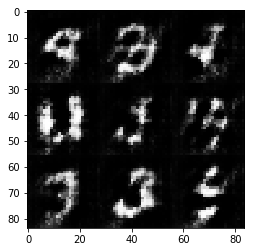

Epoch 1/2... Discriminator Loss: 1.2854... Generator Loss: 0.7794
Epoch 1/2... Discriminator Loss: 1.3360... Generator Loss: 1.3104
Epoch 1/2... Discriminator Loss: 1.3874... Generator Loss: 0.9117
Epoch 1/2... Discriminator Loss: 1.3324... Generator Loss: 0.8684
Epoch 1/2... Discriminator Loss: 1.3849... Generator Loss: 0.9643
Epoch 1/2... Discriminator Loss: 1.2879... Generator Loss: 1.2933
Epoch 1/2... Discriminator Loss: 1.2552... Generator Loss: 1.0120
Epoch 1/2... Discriminator Loss: 1.1790... Generator Loss: 1.1490
Epoch 1/2... Discriminator Loss: 1.4176... Generator Loss: 0.6726
Epoch 1/2... Discriminator Loss: 1.3495... Generator Loss: 0.9403
Epoch 1/2... Discriminator Loss: 1.3572... Generator Loss: 0.9490
Epoch 1/2... Discriminator Loss: 1.4587... Generator Loss: 0.9449
Epoch 1/2... Discriminator Loss: 1.1469... Generator Loss: 1.1476
Epoch 1/2... Discriminator Loss: 1.2361... Generator Loss: 1.0114
Epoch 1/2... Discriminator Loss: 1.2466... Generator Loss: 1.1892
Epoch 1/2.

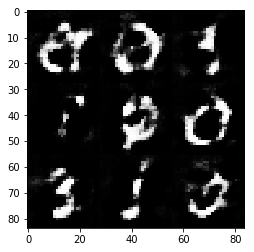

Epoch 1/2... Discriminator Loss: 1.1473... Generator Loss: 0.9797
Epoch 1/2... Discriminator Loss: 1.1515... Generator Loss: 1.1133
Epoch 1/2... Discriminator Loss: 1.3231... Generator Loss: 1.0538
Epoch 1/2... Discriminator Loss: 1.2549... Generator Loss: 0.9951
Epoch 1/2... Discriminator Loss: 1.4047... Generator Loss: 0.7555
Epoch 1/2... Discriminator Loss: 1.3223... Generator Loss: 0.7828
Epoch 1/2... Discriminator Loss: 1.1721... Generator Loss: 0.8570
Epoch 1/2... Discriminator Loss: 1.3664... Generator Loss: 1.0382
Epoch 1/2... Discriminator Loss: 1.3169... Generator Loss: 1.0024
Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 1.0545
Epoch 1/2... Discriminator Loss: 1.2188... Generator Loss: 1.1482
Epoch 1/2... Discriminator Loss: 1.4737... Generator Loss: 0.7646
Epoch 1/2... Discriminator Loss: 1.4359... Generator Loss: 0.9666
Epoch 1/2... Discriminator Loss: 1.3778... Generator Loss: 0.9615
Epoch 1/2... Discriminator Loss: 1.3426... Generator Loss: 1.0637
Epoch 1/2.

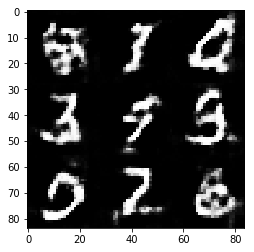

Epoch 1/2... Discriminator Loss: 1.2517... Generator Loss: 0.9154
Epoch 1/2... Discriminator Loss: 1.3851... Generator Loss: 1.0094
Epoch 1/2... Discriminator Loss: 1.1718... Generator Loss: 0.8520
Epoch 1/2... Discriminator Loss: 1.3246... Generator Loss: 1.0984
Epoch 1/2... Discriminator Loss: 1.3803... Generator Loss: 0.7187
Epoch 1/2... Discriminator Loss: 1.3911... Generator Loss: 0.8963
Epoch 1/2... Discriminator Loss: 1.3595... Generator Loss: 0.9777
Epoch 1/2... Discriminator Loss: 1.4036... Generator Loss: 0.8823
Epoch 1/2... Discriminator Loss: 1.2807... Generator Loss: 1.0788
Epoch 1/2... Discriminator Loss: 1.2562... Generator Loss: 1.0098
Epoch 1/2... Discriminator Loss: 1.1886... Generator Loss: 0.7805
Epoch 1/2... Discriminator Loss: 1.2971... Generator Loss: 1.0432
Epoch 1/2... Discriminator Loss: 1.4414... Generator Loss: 0.8563
Epoch 1/2... Discriminator Loss: 1.3248... Generator Loss: 1.0216
Epoch 1/2... Discriminator Loss: 1.2504... Generator Loss: 0.9065
End batch


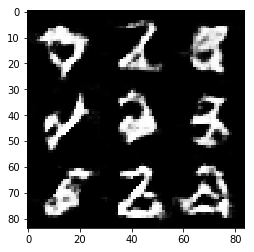

Epoch 2/2... Discriminator Loss: 1.1909... Generator Loss: 1.0874
Epoch 2/2... Discriminator Loss: 1.3517... Generator Loss: 1.0695
Epoch 2/2... Discriminator Loss: 1.3674... Generator Loss: 1.0204
Epoch 2/2... Discriminator Loss: 1.2661... Generator Loss: 0.9119
Epoch 2/2... Discriminator Loss: 1.3427... Generator Loss: 1.0414
Epoch 2/2... Discriminator Loss: 1.3822... Generator Loss: 0.9817
Epoch 2/2... Discriminator Loss: 1.3920... Generator Loss: 0.8339
Epoch 2/2... Discriminator Loss: 1.3573... Generator Loss: 0.8634
Epoch 2/2... Discriminator Loss: 1.3182... Generator Loss: 0.9535
Epoch 2/2... Discriminator Loss: 1.3483... Generator Loss: 1.0012
Epoch 2/2... Discriminator Loss: 1.3813... Generator Loss: 1.1307
Epoch 2/2... Discriminator Loss: 1.2672... Generator Loss: 1.0347
Epoch 2/2... Discriminator Loss: 1.3299... Generator Loss: 0.9408
Epoch 2/2... Discriminator Loss: 1.3502... Generator Loss: 0.9914
Epoch 2/2... Discriminator Loss: 1.2788... Generator Loss: 0.7978
Epoch 2/2.

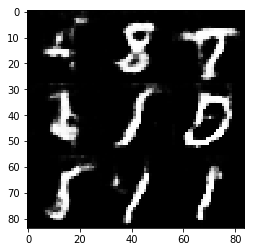

Epoch 2/2... Discriminator Loss: 1.4607... Generator Loss: 0.9110
Epoch 2/2... Discriminator Loss: 1.2558... Generator Loss: 1.0463
Epoch 2/2... Discriminator Loss: 1.2234... Generator Loss: 0.8836
Epoch 2/2... Discriminator Loss: 1.2539... Generator Loss: 1.1088
Epoch 2/2... Discriminator Loss: 1.2331... Generator Loss: 0.9532
Epoch 2/2... Discriminator Loss: 1.3135... Generator Loss: 0.9828
Epoch 2/2... Discriminator Loss: 1.2353... Generator Loss: 0.8723
Epoch 2/2... Discriminator Loss: 1.2667... Generator Loss: 1.0670
Epoch 2/2... Discriminator Loss: 1.3558... Generator Loss: 0.8828
Epoch 2/2... Discriminator Loss: 1.3445... Generator Loss: 0.9608
Epoch 2/2... Discriminator Loss: 1.4387... Generator Loss: 0.8550
Epoch 2/2... Discriminator Loss: 1.2416... Generator Loss: 0.9100
Epoch 2/2... Discriminator Loss: 1.3731... Generator Loss: 1.0637
Epoch 2/2... Discriminator Loss: 1.4550... Generator Loss: 0.8810
Epoch 2/2... Discriminator Loss: 1.3373... Generator Loss: 1.0132
Epoch 2/2.

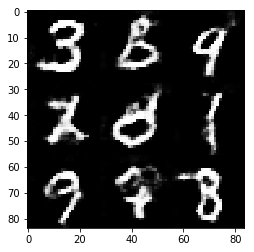

Epoch 2/2... Discriminator Loss: 1.3113... Generator Loss: 0.9104
Epoch 2/2... Discriminator Loss: 1.5062... Generator Loss: 0.8087
Epoch 2/2... Discriminator Loss: 1.3212... Generator Loss: 0.7852
Epoch 2/2... Discriminator Loss: 1.2161... Generator Loss: 0.8213
Epoch 2/2... Discriminator Loss: 1.2957... Generator Loss: 1.0060
Epoch 2/2... Discriminator Loss: 1.4170... Generator Loss: 0.9808
Epoch 2/2... Discriminator Loss: 1.2529... Generator Loss: 0.8096
Epoch 2/2... Discriminator Loss: 1.3371... Generator Loss: 0.9646
Epoch 2/2... Discriminator Loss: 1.3407... Generator Loss: 0.8923
Epoch 2/2... Discriminator Loss: 1.3673... Generator Loss: 0.9125
Epoch 2/2... Discriminator Loss: 1.3553... Generator Loss: 0.9153
Epoch 2/2... Discriminator Loss: 1.3807... Generator Loss: 0.8223
Epoch 2/2... Discriminator Loss: 1.2975... Generator Loss: 0.9145
Epoch 2/2... Discriminator Loss: 1.3275... Generator Loss: 0.8912
Epoch 2/2... Discriminator Loss: 1.2836... Generator Loss: 0.8055
Epoch 2/2.

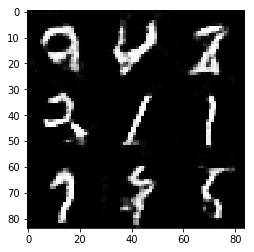

Epoch 2/2... Discriminator Loss: 1.3541... Generator Loss: 0.8845
Epoch 2/2... Discriminator Loss: 1.3396... Generator Loss: 0.9920
Epoch 2/2... Discriminator Loss: 1.3876... Generator Loss: 0.8328
Epoch 2/2... Discriminator Loss: 1.3263... Generator Loss: 0.9054
Epoch 2/2... Discriminator Loss: 1.2969... Generator Loss: 0.9167
Epoch 2/2... Discriminator Loss: 1.3641... Generator Loss: 0.8682
Epoch 2/2... Discriminator Loss: 1.4365... Generator Loss: 0.9793
Epoch 2/2... Discriminator Loss: 1.4017... Generator Loss: 0.8271
Epoch 2/2... Discriminator Loss: 1.3063... Generator Loss: 0.8793
Epoch 2/2... Discriminator Loss: 1.4173... Generator Loss: 0.8554
End batch
End epoch
Final images:


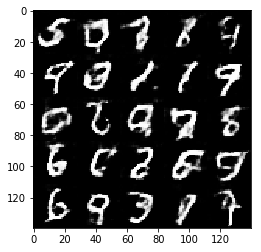

End


In [15]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0545... Generator Loss: 1.4020
Epoch 1/1... Discriminator Loss: 0.8712... Generator Loss: 1.6260
Epoch 1/1... Discriminator Loss: 0.9545... Generator Loss: 1.7731
Epoch 1/1... Discriminator Loss: 0.8409... Generator Loss: 2.2744
Epoch 1/1... Discriminator Loss: 0.8791... Generator Loss: 1.6665
Epoch 1/1... Discriminator Loss: 0.7571... Generator Loss: 2.7217
Epoch 1/1... Discriminator Loss: 0.8652... Generator Loss: 2.4934
Epoch 1/1... Discriminator Loss: 0.6321... Generator Loss: 2.4798
Epoch 1/1... Discriminator Loss: 0.9874... Generator Loss: 1.5143
Epoch 1/1... Discriminator Loss: 0.6680... Generator Loss: 2.8223
Epoch 1/1... Discriminator Loss: 0.5822... Generator Loss: 3.0794
Epoch 1/1... Discriminator Loss: 0.5334... Generator Loss: 2.8285
Epoch 1/1... Discriminator Loss: 0.5158... Generator Loss: 2.8594
Epoch 1/1... Discriminator Loss: 0.6424... Generator Loss: 2.4482
Epoch 1/1... Discriminator Loss: 0.6275... Generator Loss: 3.1493
Epoch 1/1.

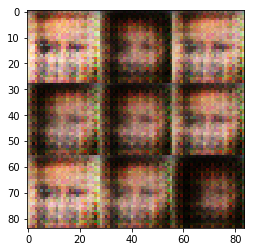

Epoch 1/1... Discriminator Loss: 0.8698... Generator Loss: 1.5849
Epoch 1/1... Discriminator Loss: 1.5635... Generator Loss: 0.9169
Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 1.2355
Epoch 1/1... Discriminator Loss: 1.2733... Generator Loss: 1.5198
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 1.2255
Epoch 1/1... Discriminator Loss: 0.9236... Generator Loss: 1.6932
Epoch 1/1... Discriminator Loss: 1.1897... Generator Loss: 1.5082
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 1.0740
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 1.4055
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 1.5706
Epoch 1/1... Discriminator Loss: 1.1373... Generator Loss: 1.2662
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 1.3406
Epoch 1/1... Discriminator Loss: 1.2482... Generator Loss: 1.1032
Epoch 1/1... Discriminator Loss: 1.4204... Generator Loss: 1.3040
Epoch 1/1... Discriminator Loss: 1.3146... Generator Loss: 1.1986
Epoch 1/1.

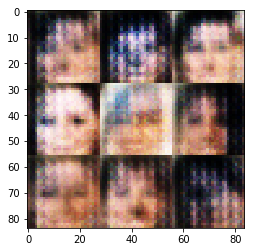

Epoch 1/1... Discriminator Loss: 1.2975... Generator Loss: 1.2580
Epoch 1/1... Discriminator Loss: 1.1390... Generator Loss: 1.3512
Epoch 1/1... Discriminator Loss: 1.2222... Generator Loss: 1.2563
Epoch 1/1... Discriminator Loss: 1.0923... Generator Loss: 1.4015
Epoch 1/1... Discriminator Loss: 1.2668... Generator Loss: 1.0369
Epoch 1/1... Discriminator Loss: 1.1832... Generator Loss: 1.0895
Epoch 1/1... Discriminator Loss: 1.1920... Generator Loss: 1.1409
Epoch 1/1... Discriminator Loss: 1.0778... Generator Loss: 1.1532
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 1.1271
Epoch 1/1... Discriminator Loss: 1.1719... Generator Loss: 1.3942
Epoch 1/1... Discriminator Loss: 1.2777... Generator Loss: 1.2423
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 1.0762
Epoch 1/1... Discriminator Loss: 1.2579... Generator Loss: 1.6407
Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.9008
Epoch 1/1.

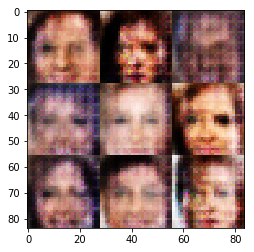

Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.8467
Epoch 1/1... Discriminator Loss: 1.3514... Generator Loss: 0.9329
Epoch 1/1... Discriminator Loss: 1.4148... Generator Loss: 0.9851
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.9898
Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.9554
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 1.3531... Generator Loss: 0.7855
Epoch 1/1... Discriminator Loss: 1.3891... Generator Loss: 1.0052
Epoch 1/1... Discriminator Loss: 1.4652... Generator Loss: 0.9565
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.9939
Epoch 1/1... Discriminator Loss: 1.2468... Generator Loss: 0.8890
Epoch 1/1... Discriminator Loss: 1.4783... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.8068
Epoch 1/1... Discriminator Loss: 1.4494... Generator Loss: 0.8810
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.8354
Epoch 1/1.

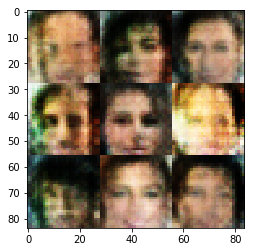

Epoch 1/1... Discriminator Loss: 1.4467... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.9038
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.5024... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.3546... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.3597... Generator Loss: 0.9730
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 1.0229
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7844
Epoch 1/1... Discriminator Loss: 1.4132... Generator Loss: 0.9338
Epoch 1/1... Discriminator Loss: 1.4434... Generator Loss: 0.9671
Epoch 1/1... Discriminator Loss: 1.3324... Generator Loss: 0.9739
Epoch 1/1... Discriminator Loss: 1.4668... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.3615... Generator Loss: 0.9412
Epoch 1/1... Discriminator Loss: 1.2607... Generator Loss: 1.0737
Epoch 1/1.

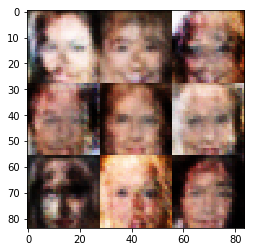

Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.8648
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 1.0108
Epoch 1/1... Discriminator Loss: 1.4041... Generator Loss: 0.9332
Epoch 1/1... Discriminator Loss: 1.3913... Generator Loss: 0.9035
Epoch 1/1... Discriminator Loss: 1.5381... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.9114
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 0.8345
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.8562
Epoch 1/1... Discriminator Loss: 1.3521... Generator Loss: 0.9643
Epoch 1/1... Discriminator Loss: 1.3378... Generator Loss: 0.8628
Epoch 1/1... Discriminator Loss: 1.2189... Generator Loss: 0.8821
Epoch 1/1... Discriminator Loss: 1.4122... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 1.4493... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.4357... Generator Loss: 0.8575
Epoch 1/1.

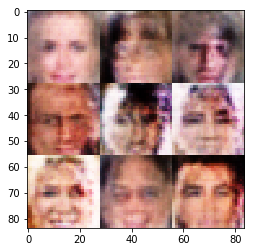

Epoch 1/1... Discriminator Loss: 1.2780... Generator Loss: 0.9819
Epoch 1/1... Discriminator Loss: 1.2683... Generator Loss: 0.8973
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 0.9516
Epoch 1/1... Discriminator Loss: 1.1898... Generator Loss: 0.9184
Epoch 1/1... Discriminator Loss: 1.2863... Generator Loss: 0.9327
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.8694
End batch
End epoch
Final images:


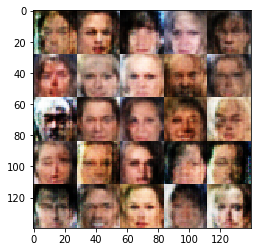

End


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.